# Stretch PIMU Guide: Interpreting Sensor Data

The Stretch Body Pimu package provides a Python API to the Stretch RE1 Power and IMU Board (PIMU). In this guide, we'll look at using the stretch_pimu_jog.py and stretch_pimu_scope.py files to get a idea about the status of base.

## Setup

Stretch Body is available on PyPi as [hello-robot-stretch-body](https://pypi.org/project/hello-robot-stretch-body/). An accompanying command-line tools package called [hello-robot-stretch-body-tools](https://pypi.org/project/hello-robot-stretch-body-tools/) uses Stretch Body to provide convenient scripts to interact with the robot from the command-line. Both come preinstalled on Stretch RE1, but the following command can be used to ensure you have the latest version.

In Jupyter notebooks, code preceded by `!` are run in the command-line instead of the Python interpreter.

In [ ]:
!python -m pip install -q -U hello-robot-stretch-body
!python -m pip list | grep hello-robot-stretch-body

# Stretch Body PIMU jog

The Stretch body PIMU jog file is available at stretch_body/tools/bin/stretch_pimu_jog.py, this file provides an easy way to interact with the Base board. This can be helpful to ping any componenet in the base board.

In [1]:
from stretch_body.pimu import Pimu
import time

Now, we'll instantiate an object of Pimu and call it `p`.

In [2]:
p = Pimu()

The cell below displays the docstring for `startup()`. As you can see, the method returns a boolean depending on whether or not the class startup procedure succeeded. Only one instance of the pimu class can exist at once, so if another instance is running elsewhere, the method returns false.

In [3]:
p.startup?

Below, we make the call to `startup()`. As part of the startup procedure, this method opens serial ports to the hardware devices, loads the parameters that dictate robot behavior, and launches a few helper threads to poll for status in the background. If it successfully does that then it should return True.

In [4]:
p.startup()

True

If startup fails unexpectedly, the first thing to check is whether a background process is already running an instance of the robot class. Below we use the `pstree` command to list the tree of background processes, and `grep` to filter for scripts starting with "stretch_" (often the "stretch_xbox_controller_teleop.py" scripts is running in the background). If we see output below, we should use the `pkill` command to [terminate the conflicting process](https://docs.hello-robot.com/troubleshooting_guide/#rpc-transport-errors-stretch-doesnt-respond-to-commands).

In [ ]:
!pstree | grep stretch_

The second method we'll look at is called `stop()`. This method closes connections to all serial ports, releases other resources, and shuts down background threads. We'll wait until the end of the notebook to actually call the method.

In [ ]:
p.stop?

The next method we'll look at is called `pretty_print()`. This method prints out the entire state of the PIMU in a human readable format.

In [ ]:
p.pretty_print()

we'd often like to be able to access the robot's state programmatically. The pull_status() method returns a dictionary with a snapshot of the current state of the PIMU. This can be accessed through the status dictionary and specifying the keyword. Here for example the status of fan is displayed.

In [5]:
p.pull_status()
p.status['fan_on']

False

# User/Utlity Functions 

Next, let's take a look at how we can use the User and Utility Functions in the Pimu class to access PIMU board.

These functions are mostly designed to be used during normal operation of stretch body or during development/factory use.

Note: All the functions require to be followed by the `push_command()`. The functions add the query to the Python API queue and push command is required to push the queue to hardware drivers.

IMU RESET: Toggles the reset line to the IMU chip. This potentially could be useful in long running robots is the IMU gets stuck in an errro state.

In [ ]:
p.imu_reset()
p.push_command()

TRIGGER MOTOR SYNC: The motor sync ensures that the motions start at exactly the right time. Otherwise there can be a slight delay (~10ms) between the start of motion for each joint.  If motor sync is enabled (via YAML) for the four stepper motors, using `move_to` and `push_command` gets the motion command down to the four stepper motors. But they won't start moving until `trigger_motor_sync` is called.

In [ ]:
p.trigger_motor_sync()
p.push_command()

SET_FAN_ON and SET_FAN_OFF: This function is used to set the fan in the PIMU board to on or off. We can use the p.pull_status to fetch the status and use p.status['keyword_name'] to display the status. For Fan, we can see if the fan is currently running or not and toggle it to on or off. Stretch body uses Intel-NUC and the fan is useful to prevent issues resulting from overheating.

In [ ]:
p.pull_status()
if p.status['fan_on']:
    p.set_fan_off()
else:
    p.set_fan_on()
p.push_command()

SET_BUZZER_ON and SET_BUZZER_OFF: Same as in fan, these functions are used to trigger the buzzer on or off. The status values can be used to plot if 

In [ ]:
if p.status['buzzer_on']:
    p.set_buzzer_off()
else:
    p.set_buzzer_on()
p.push_command()

BOARD_RESET: board_reset will cause the SAMD microcontroller on the board to reset (as if the board was power cycled). Users generally don't need to call this.

In [ ]:
p.board_reset()
p.push_command()

CLIFF_EVENT_RESET: The cliff sensors can be configured via YAML to put the robot in pause/runstop mode when they are outside of a threshold value. This will cause the robot to stop when it approaches a cliff. In order to reset this event and allow motion to resume this function must be called. By default we have this functionality turned off at the factory as it isn't well tested.

In [ ]:
p.cliff_event_reset()
p.push_command()

RUNSTOP_EVENT_RESET: Reset the robot runstop, allowing motion to continue.

In [ ]:
p.runstop_event_reset()
p.push_command()

RUNSTOP_EVENT_TRIGGER: Trigger the robot runstop, stopping motion.

In [ ]:
p.runstop_event_trigger()
p.push_command()

TRIGGER_BEEP: You should hear a beep after running this command. This is useful sometimes for generating a sounds wave that can be helped to check if the bump sensors are working as expected. Generate a single short beep.

In [ ]:
p.trigger_beep()
p.push_command()

# Visualising the status values.

It might be useful to actually visualise the continous status values of the PIMU. This involves pulling the status values from various sensors continously and plotting it on a graph. This method could be super helpful to understand how changes in the environment change the sensor readings and robot's status.

Let's install the required libraries for visualisation

In [6]:
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [7]:
def get_reading(p, params, functions=None):
    p.pull_status()
    value = p.status[params[0]]
    for key in params[1:]:
        value = value[key]
    if functions != None:
        for function in functions:
            value = function(value)
    return value

In [8]:
def plot_values(num_points, run_time, p, params, y_range=None, functions=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 
    
    new_val = get_reading(p, params, functions)


    data = np.full(num_points, new_val)

    for _ in range(run_time*2):
        new_val = get_reading(p, params, functions)
        print("new val is ", new_val)
        
        data=np.roll(data,-1)
        data[-1]=new_val

        ax.cla()
        ax.plot(data)
        if y_range == None:
            ax.set_ylim([new_val-0.1,new_val+0.1])
        else:
            ax.set_ylim(y_range)
        display(fig)

        clear_output(wait = True)
        plt.pause(0.5)

In [9]:
def plot_values_4(num_points, run_time, p, params, yrange = None, functions=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 
    
    new_val = get_reading(p, params, functions)
    print(new_val)

    data = np.full([num_points,4], new_val)

    for _ in range(run_time*2):

        new_val = get_reading(p, params, functions)
        
        print("new val is ", new_val)
        data=np.roll(data,-1,0)
        data[-1]=new_val

        ax.cla()
        ax.plot(data)
        ax.set_ylim(yrange)
        display(fig)

        clear_output(wait = True)
        plt.pause(0.5)

The value `num_points` signifies the number of values that will be plotted at a point in the line plot. `run_time` signifies the time in seconds till which the visualisation will run. New status value is pulled twise every second. `yrange` signifies the range of y-axis. If this is set to None, the visualisation will set the range as +/- 0.1 of current value. The `params` argument expects a list of the key values to access status. This is used for accessing specific sensor readings within certain devices. The `functions` argument expects a list of functions that could be applied to the values before visualising.

cliff: Scope base cliff sensors. The cliff sensors are helpful in indicating if the robot is at the edge of a fall or inclined. Try to lighly lift the robot from one side and notice how the sensor value spikes (be careful to not lift is too high as to topple Stretch). The forum post might be helpful when setting up yrange for cliff sensors - https://forum.hello-robot.com/t/working-with-cliff-sensors/88

In [ ]:
num_points = 20
run_time = 10
yrange = [-50, 275]

plot_values_4(num_points, run_time, p, ["cliff_range"], yrange)

at_cliff: Scope base at_cliff signal

In [ ]:
num_points = 20
run_time = 10
yrange = [-0.25,1.25]

plot_values_4(num_points, run_time, p, ["at_cliff"], yrange)

voltage: Scope bus voltage (V). This value is helpful for measuring the state of the battery in the robot. If battery is low, this value would be low. It is good practice to not let the voltage value get too low before a recharge.

('new val is ', 13.62928032875061)


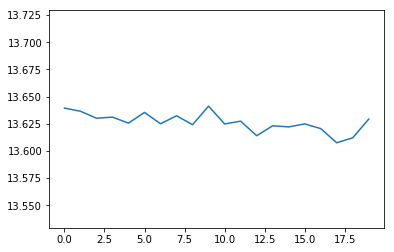

In [10]:
num_points = 20
run_time = 30
# yrange = [12,15]
yrange = None
plot_values(num_points, run_time, p, ["voltage"], yrange)

current: Scope bus current (A)

In [ ]:
num_points = 20
run_time = 10
yrange = [0,5]

plot_values(num_points, run_time, p, ["current"], yrange)

temp: Scope base internal temperature (C)

In [ ]:
num_points = 20
run_time = 10
# yrange = [0,50]
yrange= None

plot_values(num_points, run_time, p, ["temp"], yrange)

IMU sensor readings: IMU stands for “Inertial Measurement Unit,” and it is used to capture data about the device’s movement. The IMU has accelerometer, gyroscope, magnetometer.

The raw data collected from an IMU gives some idea of the world around it, but that information can also be processed for additional insight. Sensor fusion is the (mathematical) art of combining the data from each sensor in an IMU to create a more complete picture of the device’s orientation and heading. For instance, while looking at gyroscope information for rotational motion, you can incorporate an accelerometers sense of gravity to create a reference frame.

The accelerometer measure the velocity and acceleration in the x,y,z direction.

ax: Scope base accelerometer AX

In [ ]:
num_points = 20
run_time = 10
yrange = [-2,2]

plot_values(num_points, run_time, p, ["imu","ax"], yrange)

ay: Scope base accelerometer AY

In [ ]:
num_points = 20
run_time = 10
yrange = [-2,2]

plot_values(num_points, run_time, p, ["imu","ay"], yrange)

az: Scope base accelerometer AZ

In [ ]:
num_points = 20
run_time = 10
yrange = [-11,-8]

plot_values(num_points, run_time, p, ["imu","az"], yrange)

The magnenometer establishes cardinal direction.

mx: Scope base magnetometer MX

In [ ]:
num_points = 20
run_time = 10
yrange = [-20,20]

plot_values(num_points, run_time, p, ["imu","mx"], yrange)

my: Scope base magnetometer MY

In [ ]:
num_points = 20
run_time = 10
yrange = [-20,20]

plot_values(num_points, run_time, p, ["imu","my"], yrange)

mz: Scope base magnetometer MZ

In [ ]:
num_points = 20
run_time = 10
yrange = [-20,20]

plot_values(num_points, run_time, p, ["imu","mz"], yrange)

 The gyrocope measures the rotation and rotational rate.

gx: Scope base gyro GX

In [ ]:
num_points = 20
run_time = 10
# yrange = [-2,2]
yrange=None
plot_values(num_points, run_time, p, ["imu","gx"], yrange)

gy: Scope base gyro GY

In [ ]:
num_points = 20
run_time = 10
# yrange = [-2,2]
yrange=None
plot_values(num_points, run_time, p, ["imu","gy"], yrange)

gz: Scope base gyro GZ

In [ ]:
num_points = 20
run_time = 10
# yrange = [-2,2]
yrange=None
plot_values(num_points, run_time, p, ["imu","gz"], yrange)

roll: Scope base imu Roll

In [ ]:
num_points = 20
run_time = 10
# yrange = [-2,2]
yrange=None
plot_values(num_points, run_time, p, ["imu","roll"], yrange)

pitch: Scope base imu Pitch

In [ ]:
num_points = 20
run_time = 10
yrange=[-20,20]

plot_values(num_points, run_time, p, ["imu","pitch"], yrange, [np.rad2deg])

heading: Scope base imu Heading

In [ ]:
num_points = 20
run_time = 10
yrange = [-10,370]

plot_values(num_points, run_time, p, ["imu","heading"], yrange,[np.rad2deg])

bump: Scope base imu bump level. The bump value is useful for indicating collision of the robot. The value spikes up when there is any collision. You can test this by lightly hitting the base (be careful to not hit too hard to damage the body)

In [ ]:
num_points = 20
run_time = 10
yrange = [-1,15]

plot_values(num_points, run_time, p, ["imu","bump"], yrange)

# Examples of using the functions

When testing out the bump function, the trigger beep could be used to generate sound vibrations that trigger the imu bump sensors. The proper working of this is a good test to see if the sensor is as sensitive as expected.

In [ ]:
num_points = 30
run_time=30
iterations=2

for _ in range(iterations):
    p.trigger_beep()
    p.push_command()
    plot_values(num_points, run_time, p, ["imu","bump"], yrange)

#####Question: Any example of trigger_motor_sync I can use here?

if motor sync is enabled (via YAML) for the four stepper motors, using `move_to` and `push_command` gets the motion command down to the four stepper motors. But they won't start moving until `trigger_motor_sync` is called.

# Wrapping Up

In this notebook, we've covered:

 * User/Utility functions in PIMU
 * Visualisation of sensor readings from the PIMU
 * Some examples of using the above

For more information on Stretch Body API, take a look at the [API Documentation](https://docs.hello-robot.com/stretch_body_guide/). To reports bugs or contribute to the library, visit the [Stretch Body Github repo](https://github.com/hello-robot/stretch_body/) where development on the library happens. Also, feel free to join our community on the [forum](https://forum.hello-robot.com/) and learn about research/projects happening with Stretch.

In [ ]:
p.stop()